In [1]:
from magpi.prelude import *
from magpi import calc
from vec_pot import *
from magpi.calc import divergence, curl, laplace
import matplotlib.pyplot as plt
from scipy.stats.qmc import Halton, Sobol
from magpi.integrate import gauss, simpson, QuadRule
from matplotlib.ticker import FormatStrFormatter
import numpy as np

jax.config.update('jax_platform_name', 'gpu')
jax.config.update("jax_enable_x64", False)
#jax.config.update("jax_enable_x64", True)
%matplotlib widget

key = random.PRNGKey(42)
jax.config.update("jax_enable_x64", False)

In [2]:
def m_flower(x):
    mx = x[..., 0] * x[..., 2]
    my = x[..., 1] * x[..., 2]# + (1 / 2 * x[..., 1] * x[..., 2]) ** 3
    mz = ones_like(my)
    mag = stack([mx, my, mz], axis=-1)
    return unit_vec(mag)

def m_vortex(x):
    x, y, z = x[..., 0], x[..., 1], x[..., 2]
    rc = 0.14
    r = sqrt(z ** 2 + x ** 2)
    k = r**2 / rc**2

    my = exp(-2 * k)
    mx = - z / r * sqrt(1 - exp(-4 * k))
    mz = x / r * sqrt(1 - exp(-4 * k))

    mag = stack([mx, my, mz], axis=-1)
    return unit_vec(mag)

domain = Cuboid(
    linspace(-0.5, 0.5, 5),
    linspace(-0.5, 0.5, 5),
    linspace(-0.5, 0.5, 5)
)

X = array(Halton(3, seed=42).random(2**12))
X = domain.transform(X)


X_val = array(Halton(3, seed=424).random(2**12))
X_val = domain.transform(X_val)

In [9]:
from typing import Any


mag = m_vortex

# class ScaledActivation(nn.Module):
#     activation: Callable

#     @nn.compact
#     def __call__(self, x) -> Any:
#         slopes = self.param('slopes', nn.initializers.constant(1), (len(x),))
#         return self.activation(slopes * x)
        

class VecPotential(nn.Module):
    @nn.compact
    def __call__(self, x):
        nodes = 10
        activation = nn.gelu
        x = domain.normalize(x)
        u = activation(nn.Dense(nodes, name="transformer1")(x))
        v = activation(nn.Dense(nodes, name="transformer2")(x))
        h = activation(nn.Dense(nodes, name="dense1")(x))
        z = activation(nn.Dense(nodes, name="dense2")(h))
        h = (1 - z) * u + z * v
        z = activation(nn.Dense(nodes, name="dense3")(h))
        h = (1 - z) * u + z * v
        y = nn.Dense(3, name="dense4")(h)
        return y



key, _k = random.split(key)
A1_model = VecPotential()
init_params = A1_model.init(_k, zeros((3,)))


def A1(x, params):
    return A1_model.apply(params, x)


@jit
def base_loss(params, data):
    lA1 = lambda x: domain.adf(x) * A1(x, params)
    def loss(x):
        return norm(laplace(lA1)(x) + curl(mag)(x)) ** 2
    return mean(vmap(loss)(data))


def shift_sample(key, x):
    k1, k2 = random.split(key)
    dir = random.uniform(k1, (3,))
    v = jnp.minimum(domain.adf(x), 0.05)
    r = random.uniform(k2, (), minval=0., maxval=v)
    return lax.stop_gradient(x + r * dir / norm(dir, keepdims=True))

def shift_samples(key, X):
    keys = asarray(random.split(key, len(X)))
    return vmap(shift_sample)(keys, X)


In [10]:
import math
def dim(params):
    return sum([math.prod(p.shape) for p in tree_leaves(params)])

dim(init_params)

35003

In [11]:
from magpi.rarc import RARC
from magpi.tr import TR
states = []

def cb(step):
    s = step
    states.append(s.state)

# solver = RARC(base_loss, tol=1e-2, r=20, q=1,
#               jit=True, maxiter=1000, callback=cb, tol_subproblem=1e-5, maxiter_subproblem=5000,
#               damping_parameter=1e-5, alpha_min=1e-6)

solver = TR(base_loss, tol=1e-2, 
              jit=True, maxiter=200, callback=cb, unroll=True, approx_hvp=False)
res = jit(solver.run)(init_params, X)

In [7]:
res = solver.run(res.params, X)

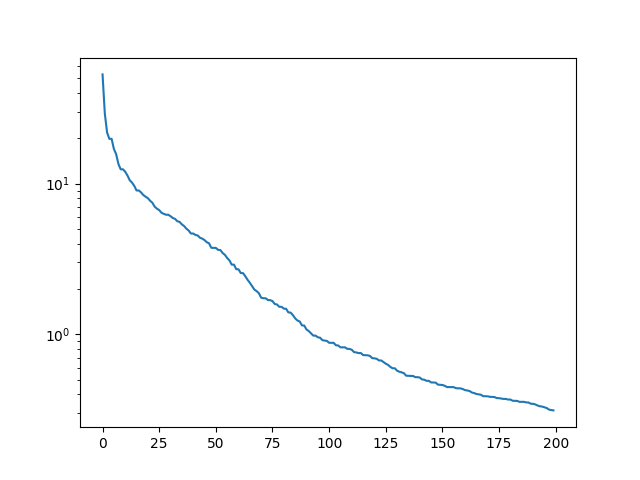

In [8]:
import matplotlib.pyplot as plt

plt.figure()
r = [jnp.min(s.value) for s in states]
#r = [tree_l2_norm(s.last_update) for s in states]
#r = [(s.iter_num_steihaug) for s in states]
plt.plot(r)
plt.yscale('log')

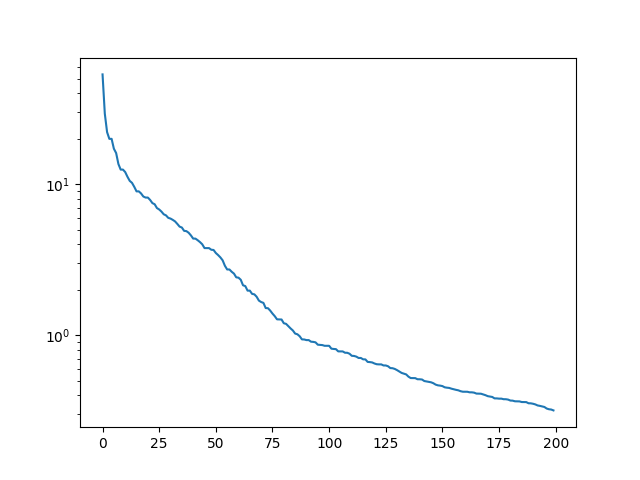

In [7]:
import matplotlib.pyplot as plt

plt.figure()
r = [jnp.min(s.value) for s in states]
#r = [tree_l2_norm(s.last_update) for s in states]
#r = [(s.iter_num_steihaug) for s in states]
plt.plot(r)
plt.yscale('log')

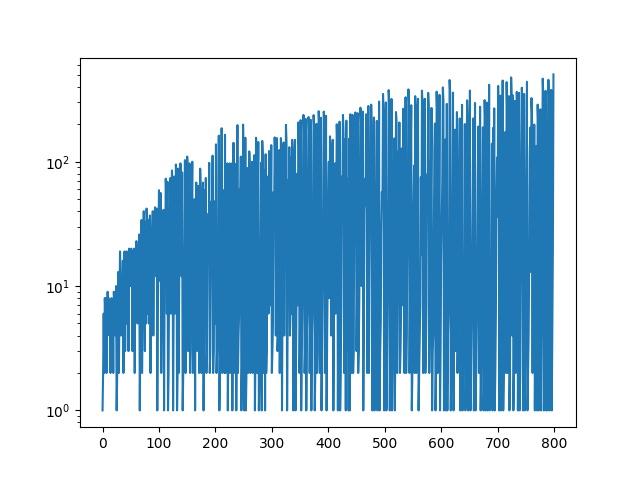

In [11]:
import matplotlib.pyplot as plt

plt.figure()
r = [jnp.min(s.value) for s in states]
#r = [tree_l2_norm(s.last_update) for s in states]
r = [(s.iter_num_steihaug) for s in states]
plt.plot(r)
plt.yscale('log')

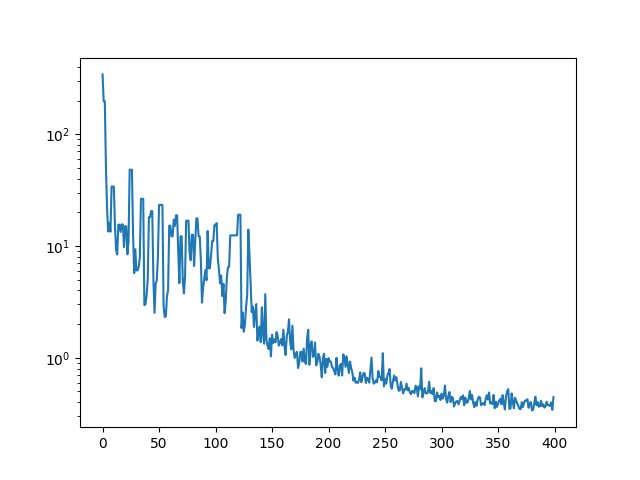

In [19]:
import matplotlib.pyplot as plt

plt.figure()
r = [jnp.min(s.value) for s in states]
#r = [tree_l2_norm(s.last_update) for s in states]
r = [(s.error) for s in states]
plt.plot(r)
plt.yscale('log')

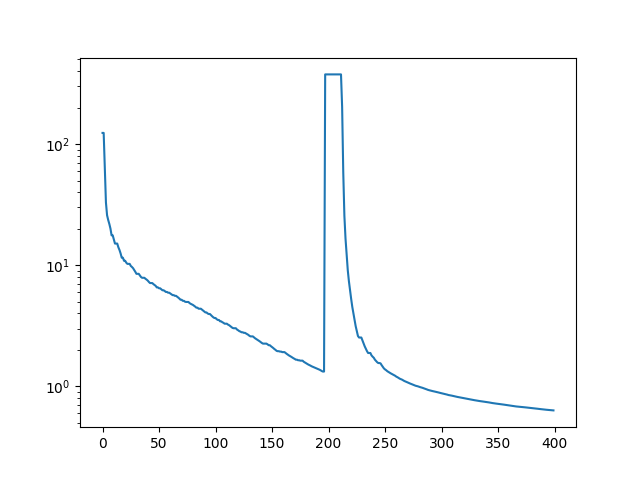

In [49]:
import matplotlib.pyplot as plt

plt.figure()
r = [s.value for s in states]
plt.plot(r)
plt.yscale('log')

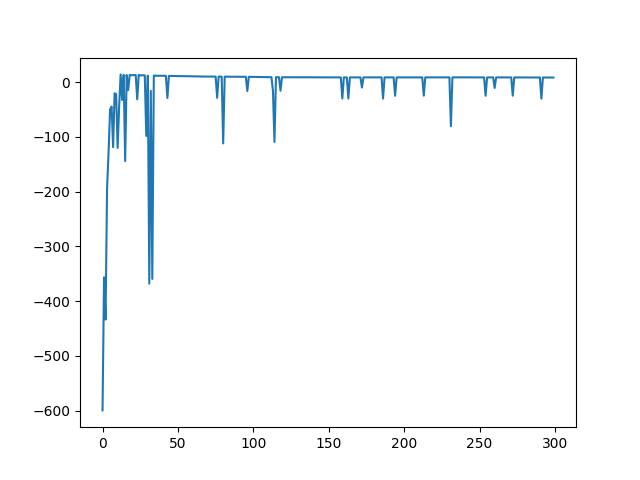

In [10]:
plt.figure()
r = [jnp.min(s.eig.eigenvalues) for s in states]
plt.plot(r)
#plt.yscale('log')

In [26]:
from jax.flatten_util import ravel_pytree
_params, unravel = ravel_pytree(res.params)
@jit
def _loss(params, X, y):
    params = unravel(params)
    return mean((model.apply(params, X) - y) ** 2)

H = jax.hessian(_loss)(_params, X, y)
S2, U2 = jnp.linalg.eigh(H)

In [27]:
S2

Array([-1.09623728e+01, -9.27386284e+00, -8.74608231e+00, -5.73456621e+00,
       -3.11723614e+00, -3.03059363e+00, -2.83503151e+00, -2.77706432e+00,
       -2.47969532e+00, -2.47959518e+00, -2.47931933e+00, -2.47931290e+00,
       -8.27756286e-01, -3.79453868e-01, -2.30751485e-01, -6.95619509e-02,
       -4.26242091e-02, -5.40321879e-03, -7.75219378e-05, -5.96096143e-05,
       -4.46398626e-05, -4.39726755e-05, -3.40385741e-05, -2.98670020e-05,
       -2.00404847e-05, -1.89492603e-05, -1.84340697e-05, -1.68235238e-05,
       -1.41999753e-05, -1.33638296e-05, -1.22435631e-05, -1.11940726e-05,
       -9.62595641e-06, -9.02732609e-06, -7.70932456e-06, -7.39213237e-06,
       -7.22388313e-06, -6.78305423e-06, -6.73891327e-06, -6.51655864e-06,
       -5.56909117e-06, -5.15739657e-06, -4.80132849e-06, -4.73992259e-06,
       -4.38454708e-06, -4.28895692e-06, -4.00163663e-06, -3.76788262e-06,
       -3.55220754e-06, -3.13441228e-06, -3.00843863e-06, -2.87175317e-06,
       -2.65832364e-06, -

In [24]:
res.state.eig.eigenvalues

Array([1323.9225  ,    9.850757,  -10.909509,   -9.319927,   -8.747832],      dtype=float32)

In [219]:
class EighResult(T.NamedTuple):
    eigenvalues: jax.Array
    eigenvectors: jax.Array

def random_eigh(
    key,
    matvec,
    Q_init,
    Q,
    r: int,
    q: int = 2,
    unroll: None | int | bool = None,
    lam_max=0.0
) -> EighResult:
    """Performs an Eigenvalue Decomposition via random subspace iteration.
    See Algorithm 4.4 and 5.3 in [1].

    Parameters
    ----------
    key : Key
    matvec : Callable[[Array], Array]
        Hermitian matrix vector product
    Q_init : chex.ArrayTree
        initial structure of vector applied to `matvec`
    r : int
        computes the `r` largest Eigenpairs of `matvec`
    q : int
        number of power iterations to run, by default 2
    unroll : None | int | bool, optional
        unroll option for `jax.lax.fori_loop`

    Returns
    -------
    tuple[Eigenvalues, Eigenvectors]

    Notes
    -----
    .. [1] Halko, Nathan, Per-Gunnar Martinsson, and Joel A. Tropp.
    "Finding structure with randomness: Probabilistic algorithms for
    constructing approximate matrix decompositions."
    SIAM review 53.2 (2011): 217-288.
    """
    _, unravel = ravel_pytree(Q_init)
    #Q = random.normal(key, (*Q.shape, r))

    # subspace iteration:

    def _matvec(Q):
        Q_new = matvec(unravel(Q))
        Q_new, _ = ravel_pytree(Q_new)
        return Q_new - lam_max * Q
    #Q = vmap(_matvec, -1, -1)(Q)
    def body(i, Q):
        Q_new = vmap(_matvec, -1, -1)(Q)
        Q_new, R = jnp.linalg.qr(Q_new)
        
        #Q = Q_new - lam_max * Q_new
        #Q_new, R = jnp.linalg.qr(Q)
        return Q_new, R

    #Q = lax.fori_loop(1, q, body, Q, unroll=unroll)
    for i in range(q):
        Q, R = body(i, Q)
    # Eigenvalue decomposition:
    def _matvec(Q):
        Q_new = matvec(unravel(Q))
        Q_new, _ = ravel_pytree(Q_new)
        return Q_new
    
    def _matvec(Q):
        Q_new = matvec(unravel(Q))
        Q_new, _ = ravel_pytree(Q_new)
        return Q_new
    Y = vmap(_matvec, -1, -1)(Q)
    B = Q.T @ Y
    S, U = jnp.linalg.eigh(B)
    U = Q @ U
    #U = vmap(unravel, -1, -1)(U)
    return EighResult(S, U)

_, g, hvp = calc.value_grad_hvp(loss, init_params, X, y)
S, U = random_eigh(key, hvp, g, U, 5, q=2, lam_max=25)

In [220]:
S, S2

(Array([-3.6591308e+00, -1.1117916e+00,  8.8817850e-15,  4.0025261e-04,
         1.8818302e-02], dtype=float32),
 Array([-3.7374134e+00, -1.6990969e+00, -3.6710281e-07, -2.6228159e-07,
        -5.8910622e-08, -4.6821924e-08, -3.5989569e-08, -2.8605173e-08,
        -2.7856505e-08, -7.1859176e-09, -2.5726863e-09, -1.0076545e-09,
         4.5441064e-09,  5.7169403e-09,  1.2116065e-08,  1.2647913e-08,
         2.0982103e-08,  2.7741873e-08,  3.3929702e-08,  6.7310687e-08,
         1.4118750e-07,  1.9515534e-07,  6.3687050e-01,  5.4135146e+00,
         2.4626572e+01], dtype=float32))

25

In [72]:
hvp = lambda p: calc.hvp_forward_over_reverse(loss, (init_params,), (p,), X, y)
_hvp = vmap(hvp, -1)
random_subspace_iteration(key, _hvp, init_params, 5, 1)

NameError: name 'random_subspace_iteration' is not defined

In [25]:
p = draw_subspace_samples(key, init_params, 1)
jvp(loss, (init_params,), (p,), X, y)

TypeError: jvp() takes from 3 to 4 positional arguments but 5 were given

In [25]:
def _for_loop(lower, upper, body_fun, init_val, unroll=False, jit=True):
    def cond_fun(state):
        i, _ = state
        return i < upper
        
    def body(state):
        i, state = state
        state = body_fun(i, state)
        return i + 1, state
    
    _, state = loop.while_loop(cond_fun, body, (lower, init_val), 
                               maxiter=upper, unroll=unroll, jit=jit)
    return state

In [47]:
from magpi.sfn import *

def _tree_set(M, v, i):
    return tree_map(lambda M, v: M.at[i].set(v), M, v)

def lanczos_iteration(k, w0, matvec_product, last_update=None, unroll=False, jit=True):
    alpha = zeros((k,))
    beta = zeros((k,))
    W = tree_map(lambda t: zeros((k, *t.shape)), w0)
    V = tree_map(lambda t: zeros((k, *t.shape)), w0)
    w_last = w0
    v_last = tree_zeros_like(w0)
    
    def body(i, state):
        (V, W, alpha, beta, v_last, w_last) = state
        beta_i = tree_l2_norm(w_last)
        vi = tree_scalar_mul(1 / beta_i, w_last)
        wi = matvec_product(vi)
        
        V = _tree_set(V, vi, i)
        W = _tree_set(W, wi, i)
        
        wi = tree_sub(wi, tree_scalar_mul(beta_i, v_last))
        alpha_i = tree_vdot(wi, vi)
        wi = tree_sub(wi, tree_scalar_mul(alpha_i, vi))
        alpha = alpha.at[i].set(alpha_i)
        beta = beta.at[i].set(beta_i)
        return (V, W, alpha, beta, vi, wi)

    state = (V, W, alpha, beta, v_last, w_last)
    (V, W, alpha, beta, _, _) = _for_loop(0, k, body, state, unroll=unroll, jit=jit)
    return V, W, alpha, beta

_loss = lambda p: loss(p, X, y)
df = grad(_loss)(init_params)
hvp = lambda t: calc.hvp_forward_over_reverse(_loss, (init_params,), (t,))
V, W, _, _ = lanczos_iteration(1, tree_negative(df), hvp)#, state.last_update)
G = tree_matmul(V, W)

In [48]:


def _hessian(G, V):
    def _dot(x, y):
        a = jnp.tensordot(x, G, ((0,), (0,)))
        b = jnp.tensordot(a, y, ((-1,), (0,)))
        return b
    right = lambda v1: tree_map(lambda v2: _dot(v1, v2), V) 
    return tree_map(right, V)

_H = _hessian(G, V)
_H["params"]["dense1"]["kernel"]["params"]["dense1"]["bias"]


Array([[[ 1.23644277e-04,  2.16343701e-02,  4.42935881e-04,
          7.41966488e-03, -1.94277875e-02],
        [ 2.16343720e-02,  3.78542423e+00,  7.75016844e-02,
          1.29823875e+00, -3.39933228e+00],
        [ 4.42935940e-04,  7.75016844e-02,  1.58674724e-03,
          2.65797693e-02, -6.95969537e-02],
        [ 7.41966534e-03,  1.29823864e+00,  2.65797656e-02,
          4.45240438e-01, -1.16582572e+00],
        [-1.94277875e-02, -3.39933205e+00, -6.95969462e-02,
         -1.16582572e+00,  3.05261946e+00]],

       [[ 5.17903900e-05,  9.06190276e-03,  1.85530793e-04,
          3.10784578e-03, -8.13764054e-03],
        [ 9.06190369e-03,  1.58558559e+00,  3.24628241e-02,
          5.43788135e-01, -1.42386484e+00],
        [ 1.85530807e-04,  3.24628204e-02,  6.64634455e-04,
          1.11333616e-02, -2.91517973e-02],
        [ 3.10784578e-03,  5.43788075e-01,  1.11333607e-02,
          1.86496094e-01, -4.88324791e-01],
        [-8.13764054e-03, -1.42386484e+00, -2.91517992e-02,
  

In [49]:
H = jax.hessian(_loss)(init_params)
H["params"]["dense1"]["kernel"]["params"]["dense1"]["bias"]

Array([[[ 8.97057238e-04,  2.16291528e-02,  4.42829158e-04,
          7.41787627e-03, -1.94231048e-02],
        [ 2.16291584e-02,  3.79341221e+00,  7.74829835e-02,
          1.29792595e+00, -3.39851213e+00],
        [ 4.42829099e-04,  7.74829760e-02,  4.68863640e-03,
          2.65733562e-02, -6.95801526e-02],
        [ 7.41787720e-03,  1.29792571e+00,  2.65733488e-02,
          4.57407564e-01, -1.16554427e+00],
        [-1.94231048e-02, -3.39851284e+00, -6.95801526e-02,
         -1.16554463e+00,  3.04369831e+00]],

       [[ 3.75746808e-04,  9.05971695e-03,  1.85486089e-04,
          3.10709653e-03, -8.13567918e-03],
        [ 9.05971974e-03,  1.58893156e+00,  3.24549899e-02,
          5.43657064e-01, -1.42352128e+00],
        [ 1.85486060e-04,  3.24549861e-02,  1.96391041e-03,
          1.11306757e-02, -2.91447621e-02],
        [ 3.10709677e-03,  5.43657005e-01,  1.11306729e-02,
          1.91592485e-01, -4.88206923e-01],
        [-8.13567918e-03, -1.42352152e+00, -2.91447621e-02,
  

In [173]:
from magpi.sfn import SFN
states = []

def cb(step):
    s = step
    states.append(s.state)

solver = SFN(loss, tol=1e-4, k=10, jit=True, 
             maxiter=1000, tol_subproblem=1e-5, init_tr_radius=0.1, max_tr_radius=0.1,
             damping_parameter=1e-3, callback=cb, maxiter_subproblem=100)
res = solver.run(init_params, X, y)

In [7]:
res.state.error, res.state.value, res.state.rho

(Array(1853.4473, dtype=float32),
 Array(51.22439, dtype=float32),
 Array(-0.28576925, dtype=float32))

In [30]:
res.state.tr_radius

Array(0.1, dtype=float32, weak_type=True)

In [31]:

loss(res.params, X, y), tree_l2_norm(res.state.last_update), res.state.rho, res.state.subproblem_converged

(Array(384279.4, dtype=float32),
 Array(0.1, dtype=float32),
 Array(0.99955773, dtype=float32),
 Array(True, dtype=bool))

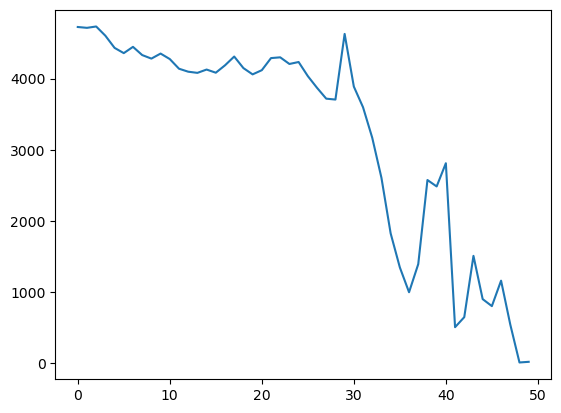

In [68]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot([s.error for s in states])

In [43]:
H = array([[1.0, 2.0, 3.0], [2.0, 1.0, 2.0], [3.0, 2.0, 1.0]])
H = H @ H

def f(x):
    x = asarray(x)
    return x @ H @ x
r0 = array([1.0, 1.2, 0.5])


In [46]:
hvp = lambda p: calc.hvp_forward_over_reverse(f, (r0,), (p,))
df = grad(f)(r0)
V, W, _, _ = lanczos_iteration(3, -df, hvp)
G = V @ W.T
_hessian(G, V)

Array([[28.01467 , 19.994326, 20.009996],
       [19.994326, 17.979872, 19.990547],
       [20.009996, 19.990545, 28.005455]], dtype=float32)

In [30]:
_hessian(G, V)

Array([[26.9479  , 21.069994, 20.173332],
       [21.069994, 17.43974 , 19.354792],
       [20.17333 , 19.354792, 28.387959]], dtype=float32)

In [31]:
jax.hessian(f)(r0)

Array([[28., 20., 20.],
       [20., 18., 20.],
       [20., 20., 28.]], dtype=float32)

In [150]:
H

Array([[14., 10., 10.],
       [10.,  9., 10.],
       [10., 10., 14.]], dtype=float32)

In [9]:
from magpi.sfn import *
solver = SFN(f, tol=1e-6, k=2, jit=True, maxiter=10, init_tr_radius=2.0, maxiter_subproblem=20, tol_subproblem=1e-5)
res = solver.run(r0)

In [36]:
from jaxopt.linear_solve import solve_lu
H = array([
    [1, -1, 0],
    [-1, 1, -1],
    [0, -1, 1.],
    ])

def f(x):
    x = asarray(x)
    return 1 / 2 * x @ H @ x
r0 = array([1,2,3.])
df = grad(f)
eigval, eigvec = jnp.linalg.eigh(H)
H_inv = lambda lam: eigvec * 1 / (jnp.abs(eigval) + lam) @ eigvec.T
x = 5 * r0#array([2, 0.5, 0.56]) 
#hvp = lambda t: calc.hvp_forward_over_reverse(f, (x,), (t,))
#alpha = -solve_lu(hvp, df(x))
#x = x / norm(x, keepdims=True)
alpha = -H_inv(0.0) @ (df(x))
x2 = x + alpha
df(x2), f(x2), f(x)

(Array([-7.071068, -9.999998, -7.071066], dtype=float32),
 Array(-241.42126, dtype=float32),
 Array(-25., dtype=float32))

In [37]:
jax.hessian(f)(r0)

Array([[ 1., -1.,  0.],
       [-1.,  1., -1.],
       [ 0., -1.,  1.]], dtype=float32)

In [42]:
hvp = lambda p: calc.hvp_forward_over_reverse(f, (r0,), (p,))
V, W, _, _ = lanczos_iteration(3, -grad(f)(r0), hvp)
G = V @ W.T
G.shape
_hessian(G, V)

Array([[ 9.9999988e-01, -1.0000000e+00,  1.0340384e-07],
       [-1.0000000e+00,  1.0000001e+00, -1.0000002e+00],
       [ 8.9458062e-08, -1.0000001e+00,  1.0000001e+00]], dtype=float32)

In [12]:
r = 0.1
g = eigvec.T @ df(x)
gl = (1 / eigval) * g
gl2 = (1 / sqrt(eigval)) * g
d = (gl @ g) ** 2 - (g.T @ g) * (((gl).T @ (gl)) - (r ** 2))

# (g @ g) / (2 * (-g @ gl + sqrt(d))), d
c = -2 * gl2 @ gl2 / (norm(g) ** 2) - 2 * r / norm(g)
lam = 1 / c

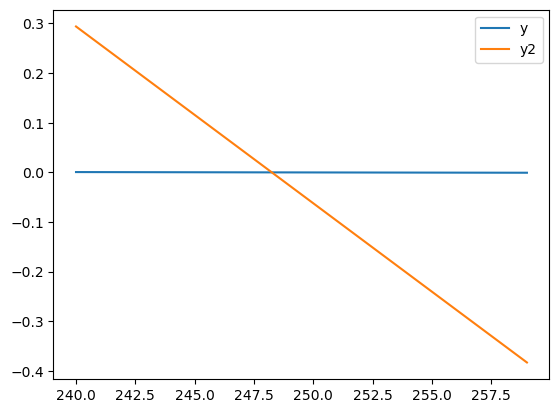

In [310]:
import matplotlib.pyplot as plt
_x = jnp.arange(240, 260, 1)
y = [norm(-H_inv(l) @ df(x))**2 - r**2 for l in _x]
y2 = [1 / r - 1/norm(-H_inv(l) @ df(x)) for l in _x]
plt.figure()
plt.plot(_x, y, label="y")
plt.plot(_x, y2, label="y2")
plt.legend()


In [321]:
norm(-H_inv(248) @ df(x)) - r

Array(8.919835e-05, dtype=float32)

In [325]:
h = df(x)
phi = lambda l: 1 / r - 1 / norm((eigvec.T @ h) * (1 / (eigval + l)))
10 - phi(10.) / jacfwd(phi)(10.)

Array(248.23785, dtype=float32)

In [307]:
h = df(x)
norm(H_inv(5) @ h), norm((eigvec.T @ h) * (1 / (eigval + 5)))

(Array(0.74855316, dtype=float32), Array(0.7485532, dtype=float32))

In [328]:
-H_inv(248.23785) @ df(x) @ df(x)

Array(-2.8077025, dtype=float32)

In [200]:
norm(alpha)

Array(2.13626, dtype=float32)

In [234]:
(gl2 @ gl2) ** 2, (g @ g) * (gl2 @ (gl2 * (1 / eigval))

(Array(588.0626, dtype=float32), Array(591.1874, dtype=float32))

In [192]:
jnp.linalg.inv(H + jnp.eye(3) * 0.1)

Array([[ 0.35758036, -0.5178662 ,  0.11367787],
       [-0.5178662 ,  1.2480574 , -0.5178661 ],
       [ 0.11367788, -0.5178661 ,  0.35758027]], dtype=float32)

In [194]:
H_inv = lambda lam: eigvec * 1 / (jnp.abs(eigval) + lam) @ eigvec.T
H_inv(1000000)

Array([[ 9.9998624e-07, -1.0034596e-11, -9.8756220e-12],
       [-1.0016698e-11,  9.9999113e-07, -9.9859730e-12],
       [-9.8772934e-12, -9.9484500e-12,  9.9998613e-07]], dtype=float32)

In [62]:
gl

Array([-0.50471073, -1.0182347 ,  1.8088859 ], dtype=float32)